In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns

from src.data_loader import DataLoader
from src.model.measurement import KEEP_COLUMNS, Measurement

In [2]:
sns.set_theme(style="darkgrid")

In [3]:
measurements = sorted(next(DataLoader.get_train_iter(batch_size=10)))
measurements

[Measurement(age=23, file=train/00000039_s005_t000.parquet),
 Measurement(age=34, file=train/00000021_s004_t000.parquet),
 Measurement(age=36, file=train/00000312_s002_t000.parquet),
 Measurement(age=36, file=train/00000466_s002_t000.parquet),
 Measurement(age=39, file=train/00000361_s003_t001.parquet),
 Measurement(age=44, file=train/00000355_s003_t000.parquet),
 Measurement(age=51, file=train/00000296_s002_t000.parquet),
 Measurement(age=58, file=train/00000407_s002_t001.parquet),
 Measurement(age=60, file=train/00000436_s002_t001.parquet),
 Measurement(age=63, file=train/00000417_s004_t000.parquet)]

In [35]:
def get_raw(measurement: Measurement) -> tuple[pd.DataFrame, mne.io.RawArray]:
    data = measurement.data

    column_map = dict(
        zip(
            [col for col in data.columns if "EEG" in col],
            [
                re.findall(r"(?<=EEG\s)(.+)(?=\-REF)", column)[0].lower().capitalize()
                for column in data.columns
                if "EEG" in column
            ],
        )
    )

    to_remove = ["Ekg1", "T1", "T2", "IBI", "BURSTS", "SUPPR"]

    columns_formatted = []
    for column in data[KEEP_COLUMNS].columns:
        mapped = column_map.get(column, column)
        if mapped in to_remove:
            continue

        columns_formatted.append(mapped)

    mapped_data = data[KEEP_COLUMNS].rename(columns=dict(zip(data[KEEP_COLUMNS].columns, columns_formatted)))
    mapped_data = mapped_data[columns_formatted]

    info = mne.create_info(
        ch_names=list(columns_formatted),
        sfreq=250,
        ch_types=["eeg"] * len(columns_formatted),
        verbose=False
    )

    raw = mne.io.RawArray(mapped_data.values.T, info, verbose=False)
    standard_montage = mne.channels.make_standard_montage("standard_1020")

    raw = raw.set_montage(standard_montage, verbose=False).filter(1, 90, verbose=False)

    # Filter 50 for European and 60 for American
    raw = raw.notch_filter(50, method="fft", verbose=False)
    raw = raw.notch_filter(60, method="fft", verbose=False)

    return mapped_data, raw


def plot_measurement(measurement: Measurement, include_ica: bool = False):
    print(f"---- AGE: {measurement.age} ----")
    _, raw = get_raw(measurement)

    raw.compute_psd(verbose=False).plot()
    raw.compute_psd(verbose=False).plot(average=True)
    plt.show()

    if include_ica:
        ica = mne.preprocessing.ICA(n_components=14, random_state=789)
        ica.fit(raw.copy(), verbose=False)
        # ica.plot_components()
        ica.plot_properties(raw)


def plot_raw(raw: mne.io.RawArray, include_ica: bool = False):
    raw.compute_psd(verbose=False).plot()
    raw.compute_psd(verbose=False).plot(average=True)
    plt.show()

    if include_ica:
        ica = mne.preprocessing.ICA(n_components=21, random_state=888)
        ica.fit(raw.copy(), verbose=False)
        ica.plot_components(inst=raw)
        ica.plot_properties(raw)

In [36]:
mapped_data, raw = get_raw(measurements[1])

/home/marek/mambaforge/envs/mp/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/marek/mambaforge/envs/mp/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


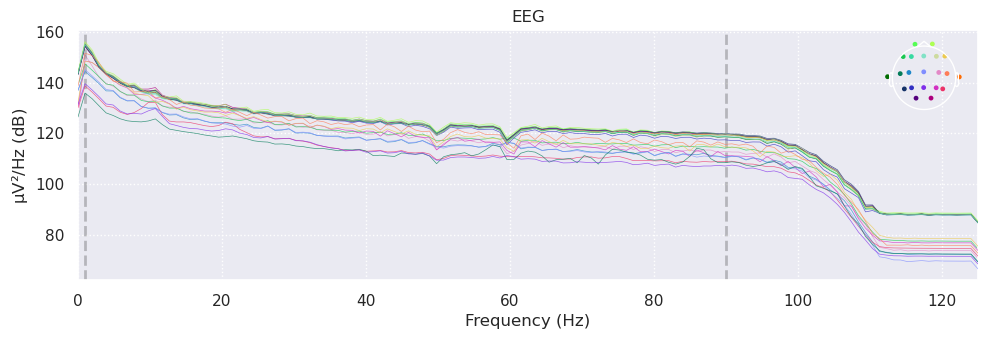

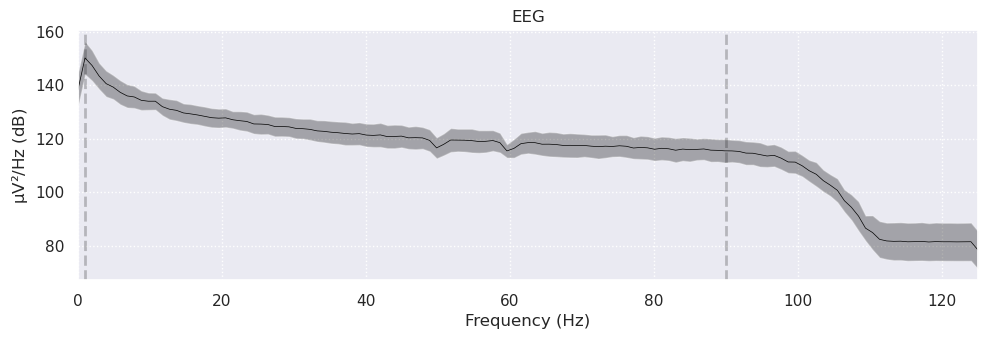

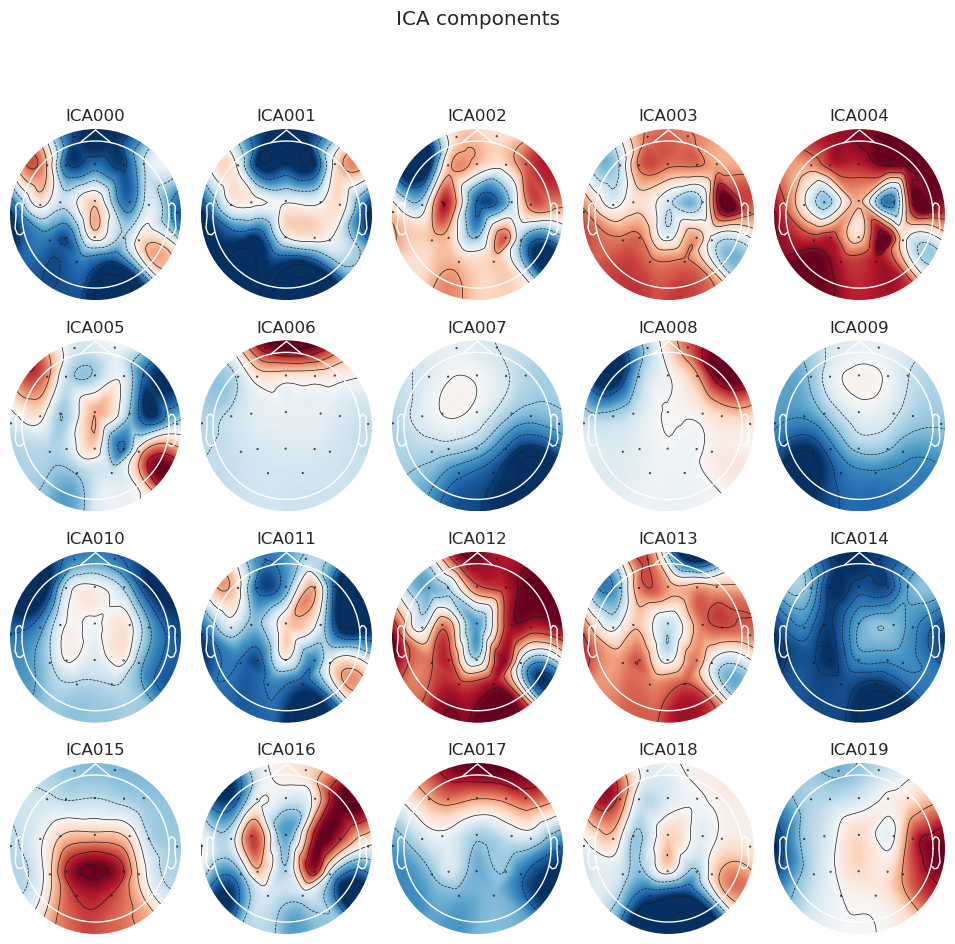

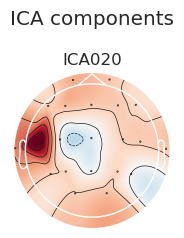

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
634 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
634 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
634 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
634 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
634 matching events found
No baseline correction applied
0 projection items activated


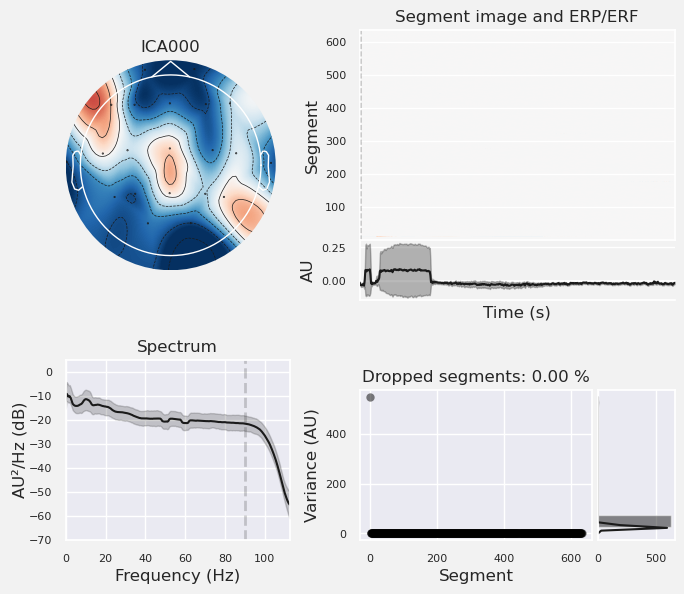

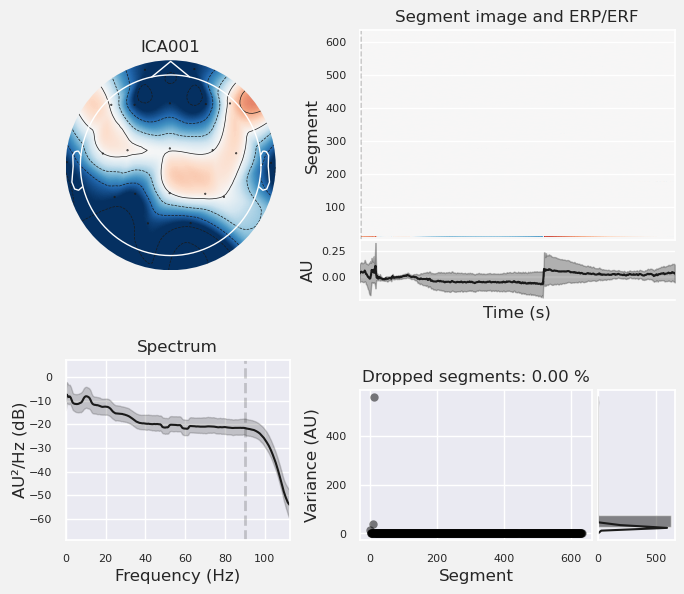

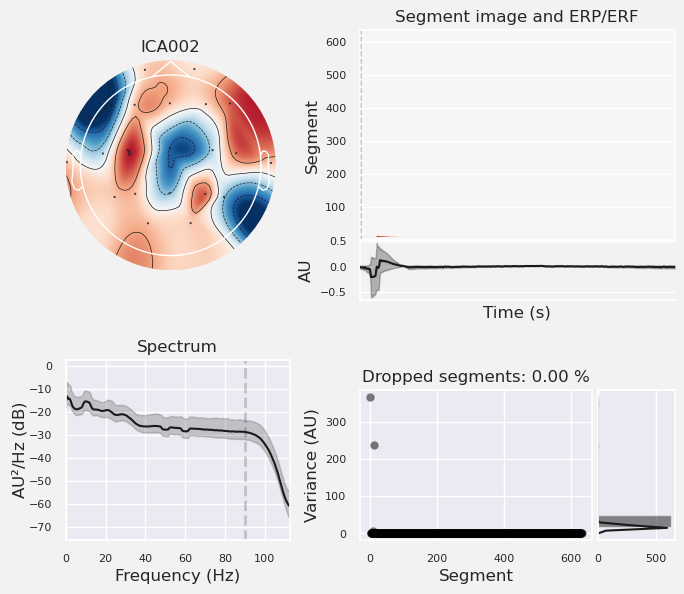

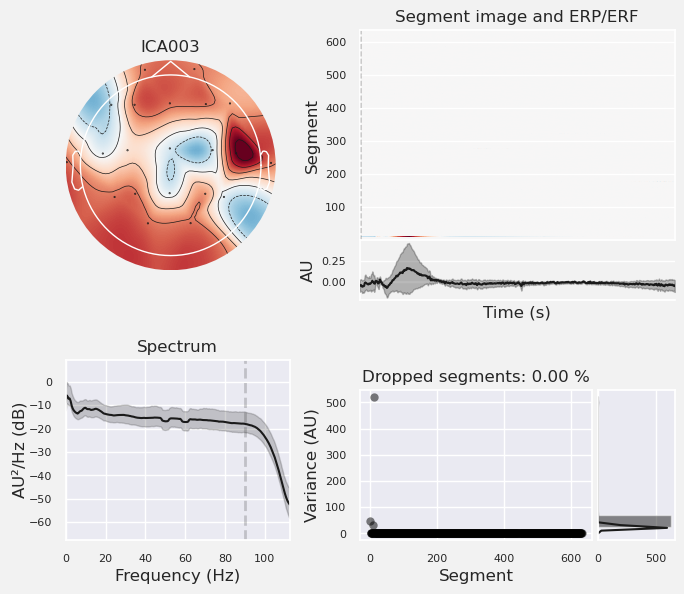

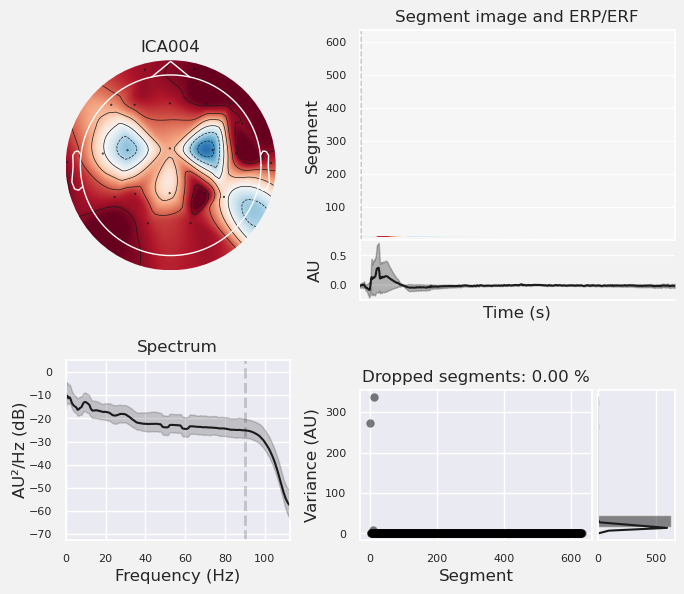

In [37]:
plot_raw(raw, include_ica=True)

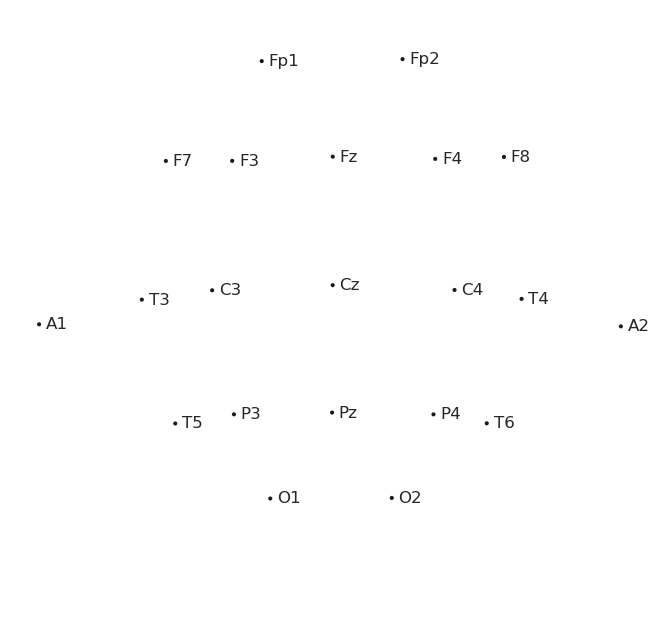

In [9]:
_ = raw.plot_sensors(show_names=True)

---- AGE: 63 ----


/home/marek/mambaforge/envs/mp/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/marek/mambaforge/envs/mp/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


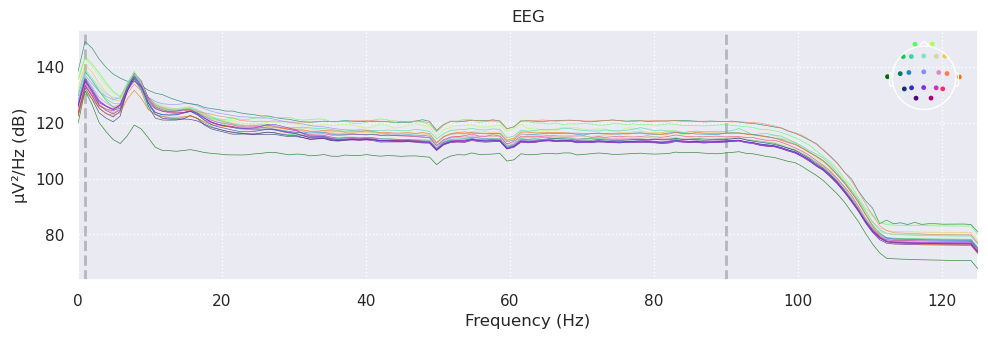

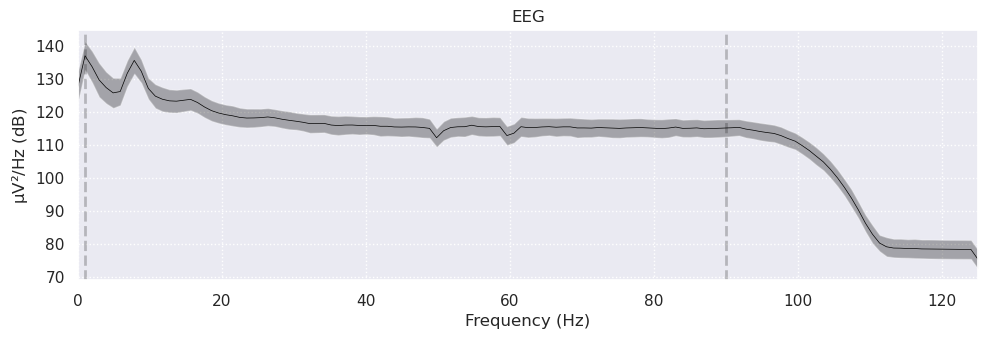

In [49]:
plot_measurement(measurements[9])
# The peak at 60hz is due to the power line frequency

---- AGE: 63 ----


/home/marek/mambaforge/envs/mp/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/marek/mambaforge/envs/mp/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


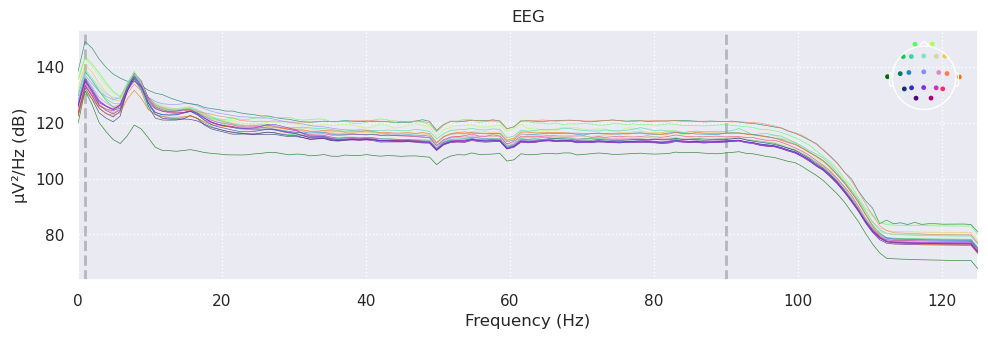

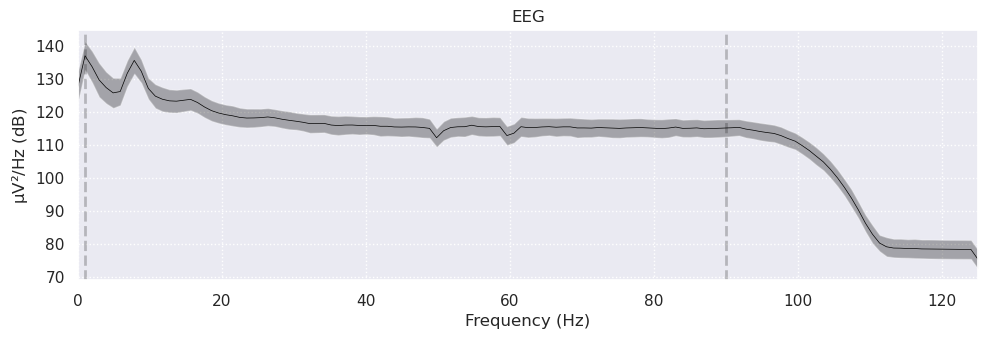

In [39]:
plot_measurement(measurements[-1])


Creating RawArray with float64 data, n_channels=21, n_times=295500
    Range : 0 ... 295499 =      0.000 ...  1181.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 825 samples (3.300 sec)

Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished


Effective window size : 1.024 (s)


/home/marek/mambaforge/envs/mp/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/marek/mambaforge/envs/mp/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


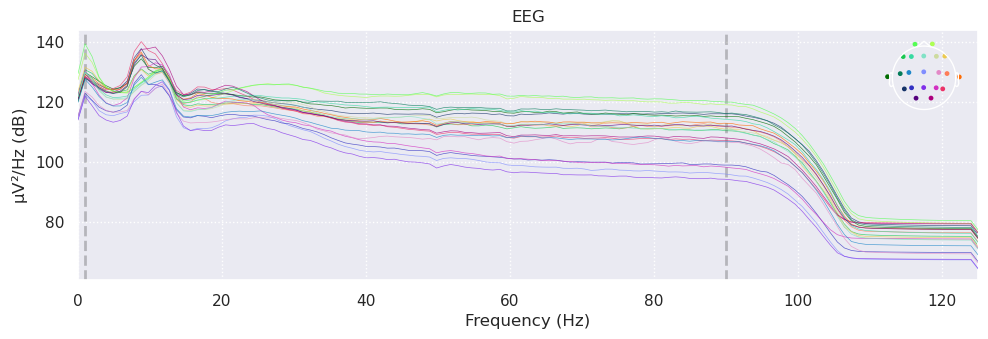

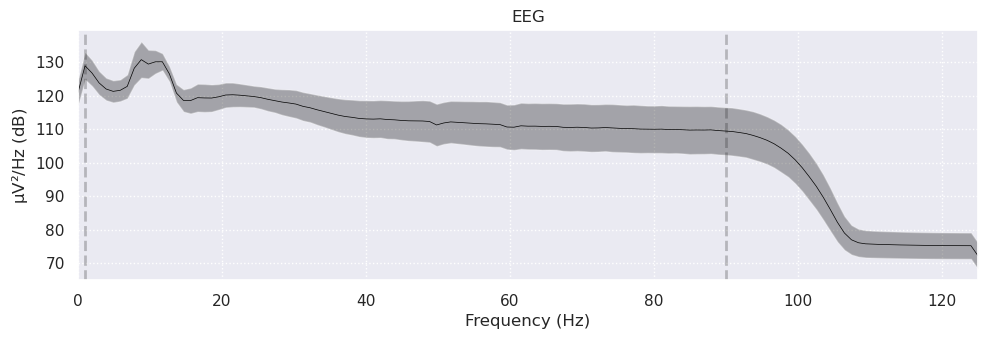

In [11]:
_, raw4 = get_raw(measurements[4])
raw4 = raw4.filter(1, 90, verbose=True)
plot_raw(raw4)

In [108]:
raw.to_data_frame()

,time,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,...,F8,T3,T4,T5,T6,A1,A2,Fz,Cz,Pz
0,0.000,6.013934e+05,5.038906e+05,6.075372e+05,-5.145495e+04,1.401414e+06,5.992122e+05,4.652698e+05,4.297985e+05,4.237672e+05,...,-2.473319e+05,7.943131e+05,7.901142e+05,1.866184e+05,4.858898e+05,2.800503e+05,9.534373e+05,2.594596e+05,659144.642580,9.118323e+05
1,0.004,2.770001e+06,4.700191e+06,9.077889e+05,-3.663057e+05,-3.931931e+05,-5.487339e+06,-1.373414e+06,-1.152021e+06,3.631745e+04,...,5.191822e+06,-1.640131e+07,-4.849501e+06,1.016900e+06,1.589027e+06,1.836658e+06,-2.183612e+05,1.577863e+06,499994.460446,2.506307e+05
2,0.008,4.243851e+05,2.457549e+06,-2.407318e+06,2.915320e+06,-3.442509e+05,-5.581574e+06,-1.966025e+06,-1.531075e+06,-2.101831e+05,...,8.676068e+06,3.559144e+06,-3.645819e+06,1.843092e+06,-7.035261e+05,-1.875173e+05,-1.526257e+06,1.237381e+06,346876.576803,-2.948622e+05
3,0.012,7.834811e+06,9.095502e+06,-1.309435e+06,7.256035e+05,-2.479541e+06,-8.054413e+06,-3.382928e+06,-4.054974e+06,-2.447527e+06,...,1.660086e+07,1.217977e+07,4.448061e+06,3.013121e+06,7.861541e+05,-1.304043e+06,6.193601e+06,2.158493e+06,373899.743540,-1.190447e+06
4,0.016,1.385476e+07,1.329141e+07,2.942893e+06,-2.537176e+06,-1.861553e+06,-1.068253e+07,-5.631202e+06,-6.344883e+06,-2.860663e+06,...,1.547956e+07,1.214757e+07,-3.331437e+06,2.475815e+06,7.250017e+04,-3.182567e+06,5.143640e+06,3.618056e+06,871574.950766,-2.338876e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329245,1316.980,-1.565709e+05,-3.464700e+05,-1.415454e+05,-1.144723e+05,-1.507539e+05,-3.709707e+05,-9.692598e+04,-2.449166e+05,-7.620070e+04,...,-3.862288e+05,-3.464358e+05,-6.034516e+05,4.945144e+04,-2.948442e+05,-6.138401e+04,-4.778369e+05,-6.859291e+04,-338038.645404,-5.217105e+05
329246,1316.984,-5.270592e+05,-1.589609e+05,-5.608217e+05,-3.917631e+04,-1.399435e+06,-5.225543e+05,-4.117453e+05,-5.646618e+05,-6.308627e+05,...,-3.908480e+05,-6.209192e+05,-3.735793e+05,-3.528114e+05,-4.443904e+05,-3.689321e+05,-5.970245e+05,-2.921686e+05,-469028.241626,-7.449577e+05
329247,1316.988,1.853369e+05,4.750167e+05,-6.088728e+04,1.735098e+05,-1.733589e+05,2.458091e+05,-2.092618e+04,1.699374e+05,-2.901449e+04,...,4.250341e+05,1.277734e+05,3.993980e+05,-1.608068e+05,2.725798e+05,-8.888428e+04,3.321400e+05,-2.562461e+04,218299.184906,3.835452e+05
329248,1316.992,6.594995e+05,2.901108e+05,4.543154e+05,1.218250e+05,1.251825e+06,5.246048e+05,3.039961e+05,5.709801e+05,5.910115e+05,...,5.400144e+05,5.147234e+05,2.961316e+05,2.635734e+05,4.973709e+05,2.831468e+05,6.170979e+05,2.398245e+05,415805.024461,7.073666e+05


In [63]:
exmpl = raw.get_data()[2]
exmpl

array([ 0.60753717,  0.9077889 , -2.4073181 , ..., -0.06088728,
        0.45431539,  0.08971464])

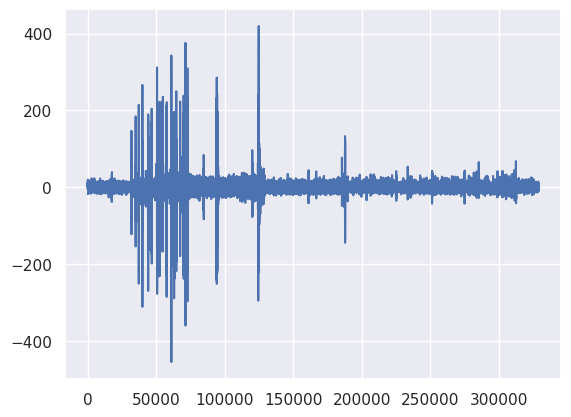

In [64]:
plt.plot(exmpl)
plt.show()

In [65]:
exmpl.shape[0] // 2

164625

In [66]:
POSITIVE_FREQS = len(exmpl) // 2 + 1
POSITIVE_FREQS

164626

In [70]:
import scipy

In [94]:
A = np.fft.fft(exmpl)

In [95]:
power = np.abs(A)
freq = np.fft.fftfreq(exmpl.shape[0])
phase = np.angle(A)

peaks = scipy.signal.find_peaks(power[freq >=0], prominence=10**4)[0]

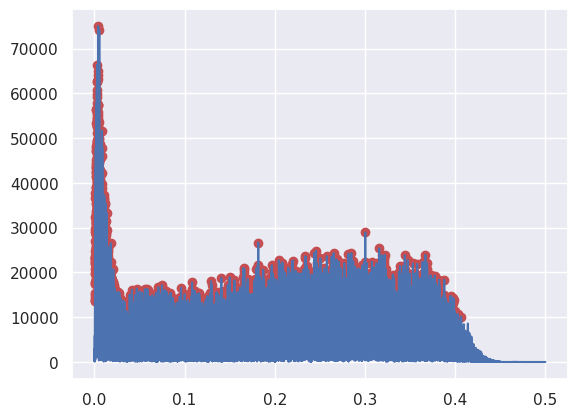

In [96]:
peak_freq = freq[peaks]
peak_power = power[peaks]
peak_phase = phase[peaks]
plt.plot(peak_freq, peak_power, "ro")
plt.plot(freq[freq >= 0], power[freq >= 0])
plt.show()

In [106]:
A[peaks], peak_freq, peak_power, peak_phase, peaks

(array([11252.68399474 +7486.89395844j,  3707.41426834+13010.49780249j,
         -323.25195557+14390.1244789j , ...,
         -875.47537124+11301.55334599j,  4159.96729688 -9911.40931077j,
        -4451.84408096 +9072.93950073j]),
 array([0.00052544, 0.00057707, 0.00061655, ..., 0.39923766, 0.40254822,
        0.40656644]),
 array([13515.78626016, 13528.41356648, 14393.75469934, ...,
        11335.41199772, 10749.01681256, 10106.29244111]),
 array([ 0.58708562,  1.29319823,  1.59325601, ...,  1.64810698,
        -1.17341061,  2.02695432]),
 array([   173,    190,    203, ..., 131449, 132539, 133862]))

In [105]:
pd.DataFrame(
    {
        "time": raw.to_data_frame().loc[peaks, "time"],
        "fft": A[peaks],
        "freq": peak_freq,
        "power": peak_power,
        "phase": peak_phase,
    }
)


,time,fft,freq,power,phase
173,0.692,11252.683995+7486.893958j,0.000525,13515.786260,0.587086
190,0.760,3707.414268+13010.497802j,0.000577,13528.413566,1.293198
203,0.812,-323.251956+14390.124479j,0.000617,14393.754699,1.593256
216,0.864,-11089.061012+8175.541880j,0.000656,13777.037387,2.506294
221,0.884,-9310.924894+12392.236488j,0.000671,15500.349917,2.215162
...,...,...,...,...,...
131261,525.044,7464.455866+11739.197902j,0.398667,13911.393488,1.004428
131349,525.396,-2244.538611-11013.551179j,0.398934,11239.940532,-1.771841
131449,525.796,-875.475371+11301.553346j,0.399238,11335.411998,1.648107
132539,530.156,4159.967297-9911.409311j,0.402548,10749.016813,-1.173411


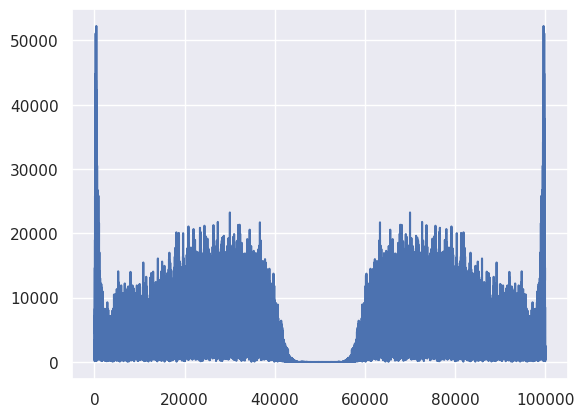

In [68]:
# Plot the magnitude of the first half of the FFT
plt.plot(np.abs(A))
plt.show()

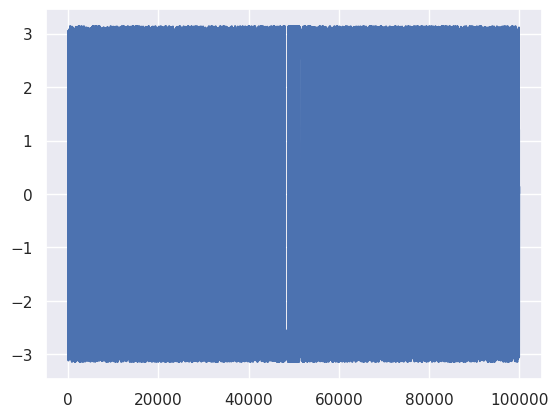

In [69]:
plt.plot(np.angle(A))
plt.show()